In [1]:
import pandas as pd
from utils_classification import *
from scipy.stats import mode

# Cross-Dataset: Ensemble prediction w/SVM style emo + RoBERTa + RoBERTa+Swin

## MAMI

In [2]:
ds_name = "MAMI"
model_name = "ensemble_svm_roberta_robertaswin"

In [3]:
#txt files with gold labels for MAMI f1 metric
gold_dev_txt = "evaluation/overlapping_classes/golds/MAMI/MAMI_validation_truth.txt"
gold_test_txt = "evaluation/overlapping_classes/golds/MAMI/MAMI_test_truth.txt"

### Binary classification

In [4]:
evaluation_type = "binary"

In [5]:
#test labels
mami_test_df = pd.read_json("../data/overlapping_classes/MAMI/MAMI_test.json",orient='index')
y_test = mami_test_df['misogynous'].to_numpy()

In [6]:
bin_label = "misogynous_prediction"
#model predictions
y_style_emo = pd.read_csv("./output/cross_dataset/MAMI/svm_stylometric_emotion_MAMI_test_binary.csv")[bin_label].to_numpy()
y_roberta = pd.read_csv("./output/cross_dataset/MAMI/roberta_MAMI_test_binary.csv")[bin_label].to_numpy()
y_multimodal = pd.read_csv("./output/cross_dataset/MAMI/multimodal_roberta_swin_MAMI_test_binary.csv")[bin_label].to_numpy()

In [7]:
predictions = np.array([y_style_emo, y_roberta, y_multimodal])
y_pred_ensemble = mode(predictions, axis=0)[0]

Saved MAMI test split binary evaluation to evaluation/overlapping_classes/predictions/MAMI/ensemble_svm_roberta_robertaswin_MAMI_test_binary.json
Saved MAMI test split to evaluation/overlapping_classes/predictions/MAMI/ensemble_svm_roberta_robertaswin_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for Ensemble (Cross-Dataset):
                precision    recall  f1-score   support

non-mysogynous       0.73      0.61      0.67       500
    misogynous       0.65      0.76      0.70       476

      accuracy                           0.69       976
     macro avg       0.69      0.69      0.69       976
  weighted avg       0.69      0.69      0.68       976

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix for Ensemble (Cr

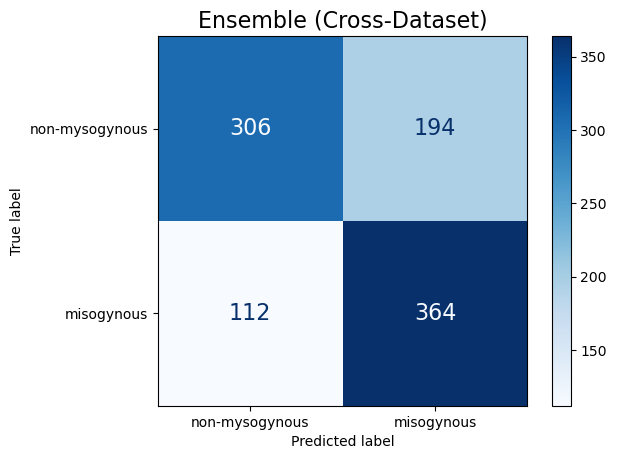

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for Ensemble (Cross-Dataset):

2025-06-24 16:37:18,056 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-06-24 16:37:18,115 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:37:18,222 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 16:37:18,222 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:37:18,330 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:37:18,431 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
T

In [8]:
gold_path_test_binary = "evaluation/overlapping_classes/golds/MAMI/MAMI_test_binary.json"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(mami_test_df, "evaluation/overlapping_classes/predictions", ds_name, "test", evaluation_type, model_name, y_pred_ensemble, "misogynous", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred_ensemble,
                               ["non-mysogynous","misogynous"],
                               gold_test_txt,test_pred_txt,
                               model_name="Ensemble (Cross-Dataset)")

In [9]:
#save predictions on test set
output_dir = f"output/cross_dataset/{ds_name}" #create output directory
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{model_name}_{ds_name}_test_{evaluation_type}.csv"

save_predictions_csv(mami_test_df, y_pred_ensemble, ["misogynous"], output_path)

Predictions saved to output/cross_dataset/MAMI/ensemble_svm_roberta_robertaswin_MAMI_test_binary.csv


### Multilabel classification

#### Hierarchical classification w/Ensemble in 1st step

In [9]:
evaluation_type = "hierarchical"
model_name = f"{model_name}_hier_ens"
#test labels
mami_label_names = ["misogynous","stereotype","objectification","violence"]
mami_test_df = pd.read_json("../data/overlapping_classes/MAMI/MAMI_test.json",orient='index')
y_test = mami_test_df[mami_label_names].to_numpy()

In [10]:
#model predictions
pred_labels = [f"{label}_prediction" for label in mami_label_names]
y_style_emo = pd.read_csv("./output/cross_dataset/MAMI/ensemble_first_step/svm_stylometric_emotion_w_ensemble_MAMI_test_hierarchical.csv")[pred_labels].to_numpy()
y_roberta = pd.read_csv("./output/cross_dataset/MAMI/ensemble_first_step/roberta_MAMI_test_hierarchical.csv")[pred_labels].to_numpy()
y_multimodal = pd.read_csv("./output/cross_dataset/MAMI/ensemble_first_step/multimodal_roberta_swin_MAMI_test_hierarchical.csv")[pred_labels].to_numpy()

In [11]:
predictions = np.array([y_style_emo, y_roberta, y_multimodal])
y_pred_ensemble = mode(predictions, axis=0)[0] #majority voting
y_pred_hierarchical = hierarchical_ensemble(y_pred_ensemble) #get hierarchical predictions (only get fine-grained labels when first column is positive)
pred_hierarchical = pd.DataFrame(y_pred_hierarchical, columns=mami_label_names) #create a df so that the predictions are saved with the evaluation functions

In [12]:
gold_path_test_binary = "evaluation/overlapping_classes/golds/MAMI/MAMI_test_hierarchical.json"
#create file with predictions
test_pred_json, test_pred_txt= save_evaluation(mami_test_df, "evaluation/overlapping_classes/predictions", ds_name, "test", evaluation_type, model_name, pred_hierarchical, "misogynous", mami_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred_hierarchical,
                               mami_label_names,
                               gold_test_txt,test_pred_txt,
                               hierarchy=True)

Saved MAMI test split hierarchical evaluation to evaluation/overlapping_classes/predictions/MAMI/ensemble_svm_roberta_robertaswin_hier_ens_MAMI_test_hierarchical.json
Saved MAMI test split to evaluation/overlapping_classes/predictions/MAMI/ensemble_svm_roberta_robertaswin_hier_ens_MAMI_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                 precision    recall  f1-score   support

 non-misogynous       0.73      0.61      0.67       500
     stereotype       0.55      0.55      0.55       350
objectification       0.54      0.59      0.56       348
       violence       0.20      0.11      0.14       153

      micro avg       0.59      0.53      0.56      1351
      macro avg       0.51      0.47      0.48      1351
   weighted avg       0.58      0.53      0.55      1351
    samples avg       0.61      0.56      0.57      1351

---------------------------------------------------------

2025-06-24 16:39:39,434 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:39:39,566 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-06-24 16:39:39,567 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:39:39,699 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-06-24 16:39:39,829 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
This is a table PyEvALL report, so no warnings or errors are shown. Please, check the embedded report to check errors if any metric has the value "-" or is an empty value or table.
	files	ICM	ICM-Norm	F1
0	ensemble_svm_roberta_robertaswin_hier_ens_MAMI_test_hierarchical.json	-0.3699091297942807	0.3826765723963306	0.4811933294521129

	files	ICM	ICM-Norm	F1
0	ensemble_svm_roberta_robertaswin_hier_ens_MA

In [8]:
#save predictions on test set
output_dir = f"output/cross_dataset/{ds_name}/ensemble_first_step" #create output directory
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{model_name}_{ds_name}_test_{evaluation_type}.csv"

save_predictions_csv(mami_test_df, y_pred_hierarchical, mami_label_names, output_path)

Predictions saved to output/cross_dataset/MAMI/ensemble_first_step/ensemble_svm_roberta_robertaswin_hier_ens_MAMI_test_hierarchical.csv


## EXIST2024

In [2]:
ds_name = "EXIST2024"
model_name = "ensemble_svm_roberta_robertaswin"

In [3]:
#txt files with gold labels for MAMI f1 metric
gold_dev_txt = "evaluation/overlapping_classes/golds/EXIST2024/EXIST2024_validation_truth.txt"
gold_test_txt = "evaluation/overlapping_classes/golds/EXIST2024/EXIST2024_test_truth.txt"

### Binary Classification

In [4]:
evaluation_type = "binary"

In [5]:
#test labels
exist_test_df = pd.read_json("../data/overlapping_classes/EXIST2024/EXIST2024_test.json",orient='index')
y_test = exist_test_df['sexist'].to_numpy()

In [6]:
bin_label = "sexist_prediction"
#model predictions
y_style_emo = pd.read_csv("./output/cross_dataset/EXIST2024/svm_stylometric_emotion_EXIST2024_test_binary.csv")[bin_label].to_numpy()
y_roberta = pd.read_csv("./output/cross_dataset/EXIST2024/roberta_EXIST2024_test_binary.csv")[bin_label].to_numpy()
y_multimodal = pd.read_csv("./output/cross_dataset/EXIST2024/multimodal_roberta_swin_EXIST2024_test_binary.csv")[bin_label].to_numpy()

In [11]:
predictions = np.array([y_style_emo, y_roberta, y_multimodal])
y_pred_ensemble = mode(predictions, axis=0)[0]

Saved EXIST2024 test split binary evaluation to evaluation/overlapping_classes/predictions/EXIST2024/ensemble_svm_roberta_robertaswin_EXIST2024_test_binary.json
Saved EXIST2024 test split to evaluation/overlapping_classes/predictions/EXIST2024/ensemble_svm_roberta_robertaswin_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for Ensemble (Cross-Dataset):
              precision    recall  f1-score   support

  non-sexist       0.70      0.61      0.65        76
      sexist       0.65      0.74      0.69        76

    accuracy                           0.67       152
   macro avg       0.67      0.67      0.67       152
weighted avg       0.67      0.67      0.67       152

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matri

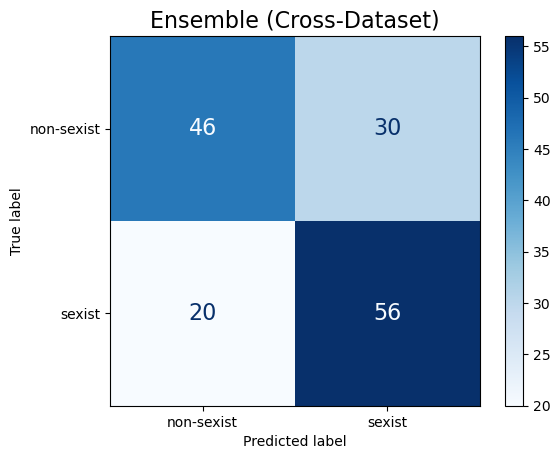

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for Ensemble (Cross-Dataset):

2025-07-18 20:12:35,471 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-07-18 20:12:36,141 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-18 20:12:36,164 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-07-18 20:12:36,165 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-18 20:12:36,181 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-18 20:12:36,196 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
T

In [12]:
gold_path_test_binary = "evaluation/overlapping_classes/golds/EXIST2024/EXIST2024_test_binary.json"
#create file with predictions
test_pred_json, test_pred_txt= save_evaluation(exist_test_df, "evaluation/overlapping_classes/predictions", ds_name, "test", evaluation_type, model_name, y_pred_ensemble, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred_ensemble,
                               ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="Ensemble (Cross-Dataset)")

In [9]:
#save predictions on test set
output_dir = f"output/cross_dataset/{ds_name}" #create output directory
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{model_name}_{ds_name}_test_{evaluation_type}.csv"

save_predictions_csv(exist_test_df, y_pred_ensemble, ["sexist"], output_path)

Predictions saved to output/cross_dataset/EXIST2024/ensemble_svm_roberta_robertaswin_EXIST2024_test_binary.csv


### Multilabel Classification

#### Hierarchical classification w/ensemble in 1st step

In [13]:
evaluation_type = "hierarchical"
model_name = f"{model_name}_hier_ens"
#test labels
exist_label_names = ["sexist","stereotyping-dominance","objectification", "sexual-violence"]
exist_test_df = pd.read_json("../data/overlapping_classes/EXIST2024/EXIST2024_test.json",orient='index')
y_test = exist_test_df[exist_label_names].to_numpy()

In [14]:
#model predictions
pred_labels = [f"{label}_prediction" for label in exist_label_names]
y_style_emo = pd.read_csv("./output/cross_dataset/EXIST2024/ensemble_first_step/svm_stylometric_emotion_w_ensemble_EXIST2024_test_hierarchical.csv")[pred_labels].to_numpy()
y_roberta = pd.read_csv("./output/cross_dataset/EXIST2024/ensemble_first_step/roberta_EXIST2024_test_hierarchical.csv")[pred_labels].to_numpy()
y_multimodal = pd.read_csv("./output/cross_dataset/EXIST2024/ensemble_first_step/multimodal_roberta_swin_EXIST2024_test_hierarchical.csv")[pred_labels].to_numpy()

In [15]:
predictions = np.array([y_style_emo, y_roberta, y_multimodal])
y_pred_ensemble = mode(predictions, axis=0)[0] #majority voting
y_pred_hierarchical = hierarchical_ensemble(y_pred_ensemble) #get hierarchical predictions (only get fine-grained labels when first column is positive)
pred_hierarchical = pd.DataFrame(y_pred_hierarchical, columns=exist_label_names) #create a df so that the predictions are saved with the evaluation functions

In [16]:
gold_path_test_binary = "evaluation/overlapping_classes/golds/EXIST2024/EXIST2024_test_hierarchical.json"
#create file with predictions
test_pred_json, test_pred_txt= save_evaluation(exist_test_df, "evaluation/overlapping_classes/predictions", ds_name, "test", evaluation_type, model_name, pred_hierarchical, "sexist", exist_label_names)
#get evaluation metrics
evaluate_multilabel_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred_hierarchical,
                               exist_label_names,
                               gold_test_txt,test_pred_txt,
                               hierarchy=True)

Saved EXIST2024 test split hierarchical evaluation to evaluation/overlapping_classes/predictions/EXIST2024/ensemble_svm_roberta_robertaswin_hier_ens_EXIST2024_test_hierarchical.json
Saved EXIST2024 test split to evaluation/overlapping_classes/predictions/EXIST2024/ensemble_svm_roberta_robertaswin_hier_ens_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report:
                        precision    recall  f1-score   support

            non-sexist       0.70      0.61      0.65        76
stereotyping-dominance       0.34      0.70      0.46        40
       objectification       0.52      0.56      0.54        43
       sexual-violence       0.21      0.19      0.20        16

             micro avg       0.49      0.58      0.53       175
             macro avg       0.44      0.51      0.46       175
          weighted avg       0.53      0.58      0.54       175
           samples avg       

In [8]:
#save predictions on test set
output_dir = f"output/cross_dataset/{ds_name}/ensemble_first_step" #create output directory
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/{model_name}_{ds_name}_test_{evaluation_type}.csv"

save_predictions_csv(exist_test_df, y_pred_hierarchical, exist_label_names, output_path)

Predictions saved to output/cross_dataset/EXIST2024/ensemble_first_step/ensemble_svm_roberta_robertaswin_hier_ens_EXIST2024_test_hierarchical.csv
